In [1]:
from math import pi
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from cowerc_adsorption import (
    PhysicalParams,
    Simulation,
    ExperimentalBreakthroughData,
    plot_btc_and_data,
)

In [2]:
excel_file = Path("../../.data/Data and Column Properties.xlsx")
sheet_name = "PFBA PFOA Competition"

In [3]:
# Read Emma's excel report
xls_setup = pd.read_excel(excel_file, sheet_name=sheet_name, nrows=19, usecols="A:B", index_col=0)
setup = xls_setup.to_dict()["Value"]

xls_influent = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=10, nrows=5, usecols="D:F")
xls_influent.set_index("Unnamed: 3", inplace=True)

xls_btc = pd.read_excel(excel_file, sheet_name=sheet_name, header=20, usecols="A:M")

In [4]:
display(xls_setup, xls_influent)

,Value
Design Parameters,
Column Diameter (cm),0.660000
Column Area (cm^2),0.340000
Particle Size (cm),0.016800
Column Diameter/Particle Size Ratio,39.285714
Reynold&apos;s Number,0.270000
Bed Voidage (ε),0.500000
Hydraulic Loading Rate (cm/s),0.080000
EBCT,0.180000
Flow Rate (mL/s),0.028000


,PFOA,PFBA
Unnamed: 3,,
Influent 1,2748.05,1019.00
Influent 2,2852.20,1058.50
Influent 3,2855.70,1075.55
Influent 4,2779.65,1007.35
Influent AVG,2808.90,1040.10


In [5]:
porosity = setup["Bed Voidage (ε)"]
lenght = setup["Bed Length (cm)"]
area = 0.25 * pi * setup["Column Diameter (cm)"] ** 2  # cm²
pore_velocity = setup["Flow Rate (mL/min)"] / (area * porosity)  # cm/min

In [6]:
xls_btc

,Sample ID,Time (min.),Cum. Vol.,Bed Vol Passed (BV),Specific Throughput,PFOA,PFOA C/C0,PFOA STDEV,PFOA STDEV C/C0,PFBA,PFBA C/C0,PFBA STDEV,PFBA STDEV C/C0
0,1,45.000000,74.25,256.034483,1237.500000,0.00,0.000000,0.000000,0.000000,120.50,0.115854,27.435743,0.026378
1,2,100.000000,165.00,568.965517,2750.000000,1.95,0.000694,2.050610,0.000730,429.60,0.413037,52.043059,0.050037
2,3,250.000000,412.50,1422.413793,6875.000000,83.05,0.029567,43.911331,0.015633,816.30,0.784828,20.930361,0.020123
3,4,592.424242,977.50,3370.689655,16291.666667,190.95,0.067980,48.861079,0.017395,1054.10,1.013460,84.994235,0.081717
4,5,1042.727273,1720.50,5932.758621,28675.000000,510.60,0.181779,8.485281,0.003021,1018.10,0.978848,2.969848,0.002855
5,6,1500.909091,2476.50,8539.655172,41275.000000,862.10,0.306917,35.213918,0.012537,1132.45,1.088790,21.849600,0.021007
6,7,2002.727273,3304.50,11394.827586,55075.000000,1132.35,0.403129,22.980970,0.008181,1007.35,0.968513,3.889087,0.003739
7,8,2674.242424,4412.50,15215.517241,73541.666667,1414.45,0.503560,40.375797,0.014374,974.65,0.937073,9.263099,0.008906
8,10,4039.090909,6664.50,22981.034483,111075.000000,1764.65,0.628235,19.021172,0.006772,1119.55,1.076387,172.321923,0.165678
9,12,5485.575758,9051.20,31211.034483,150853.333333,1995.40,0.710385,85.701342,0.030511,1036.90,0.996923,50.204581,0.048269


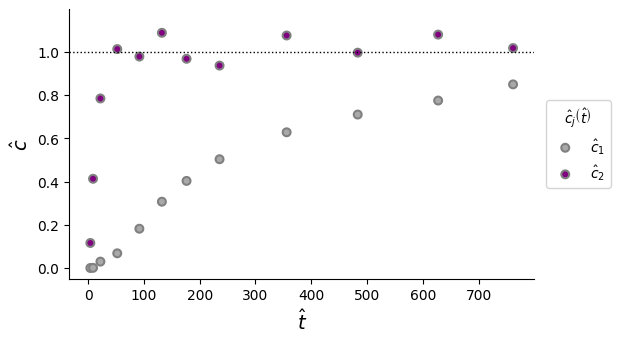

In [7]:
experimental_data = ExperimentalBreakthroughData(
    time=np.round((xls_btc["Time (min.)"] * lenght / pore_velocity), 2).to_numpy(),
    conc=xls_btc[["PFOA C/C0", "PFBA C/C0"]].to_numpy().T,
    c_0=xls_influent.loc["Influent AVG"].to_numpy(),
)

experimental_data.plot_breakthrough()

{'Dam_ads': array([17.62433479,  8.81216739]),
 'Dam_des': array([0.04406084, 0.17624335]),
 'kappa': array([0.00056178, 0.00020802]),
 'bc': array([1., 1.])}

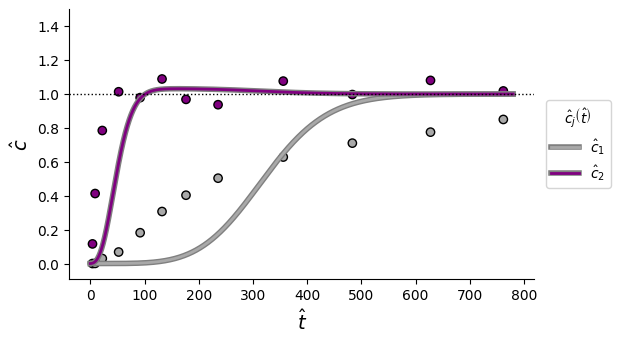

In [8]:
p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=2_500_000,
    k_ads=(200, 100),
    k_des=(0.5, 2),
    C_0=experimental_data.c_0,
)

display(p.nondim)

sim = Simulation(**p.nondim)
sim.cfl = 0.90
sim.end_time = 780
sim.solve()

fig = plot_btc_and_data(sim, experimental_data)
ax = fig.axes[0]
ax.set_ylim(top=1.5)
display(fig)

Using `curve_fit` to fit experimental data to the model

In [9]:
def logf(times_to_query, logsm, logkads_1, logkads_2, logkdes_1, logkdes_2):
    sm = 10.0**logsm
    k_ads = (10.0**logkads_1, 10.0**logkads_2)
    k_des = (10.0**logkdes_1, 10.0**logkdes_2)

    p = PhysicalParams(
        L=lenght,
        v=pore_velocity,
        n=porosity,
        sm=sm,
        k_ads=k_ads,
        k_des=k_des,
        C_0=experimental_data.c_0,  # <- Connect with experimental data
    )

    sim = Simulation(**p.nondim)
    sim.end_time = 780
    sim.cfl = 0.9
    sim.solve()

    ## Query the btc from t
    t, btc = sim.btc
    results = [np.interp(times_to_query, t, c) for c in btc]
    results = np.array(results)

    return results.flatten()


In [10]:
# Initial guess for the parameters
logp0 = 8.70, 1.70, 1.70, 0.30, -0.83

fitting_result = curve_fit(
    logf,
    xdata=experimental_data.time,
    ydata=experimental_data.conc.flatten(),
    p0=logp0,
    method="lm",
    full_output=True,
)

/tmp/ipykernel_1350042/1494260225.py:2: RuntimeWarning: overflow encountered in scalar power
  sm = 10.0**logsm


array([2.36054762e+76, 3.36149760e+01, 3.66414570e+01, 9.85921371e-02,
       2.83278934e+00])

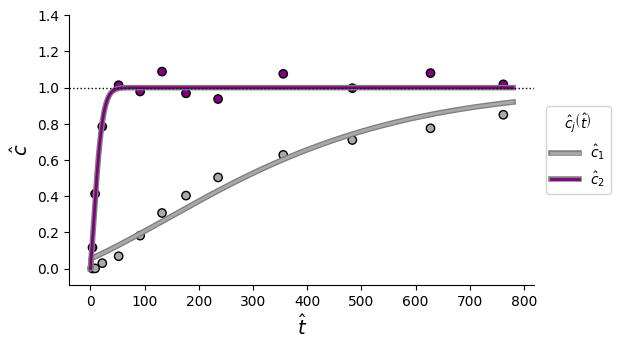

In [11]:
best_params = fitting_result[0]
best_params = 10**best_params

display(best_params)

## Show simulation with best parameters
p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=best_params[0],
    k_ads=best_params[1:3],
    k_des=best_params[3:],
    C_0=experimental_data.c_0,  # <- Connect with experimental data
)

sim = Simulation(**p.nondim)
sim.end_time = 780
sim.cfl = 0.9
sim.solve()

plot_btc_and_data(sim, experimental_data)

Fixing one of the parameters

In [12]:
def partial_logf(times_to_query, logkads_1, logkads_2, logkdes_1, logkdes_2):
    logsm = 10.5
    return logf(times_to_query, logsm, logkads_1, logkads_2, logkdes_1, logkdes_2)


# Initial guess for the parameters
logp0 = 1.70, 1.70, -1.30, 0.83

fitting_result = curve_fit(
    partial_logf,
    xdata=experimental_data.time,
    ydata=experimental_data.conc.flatten(),
    p0=logp0,
    method="lm",
    full_output=True,
)

array([33.61494812, 36.64142007,  0.09859071,  2.83278279])

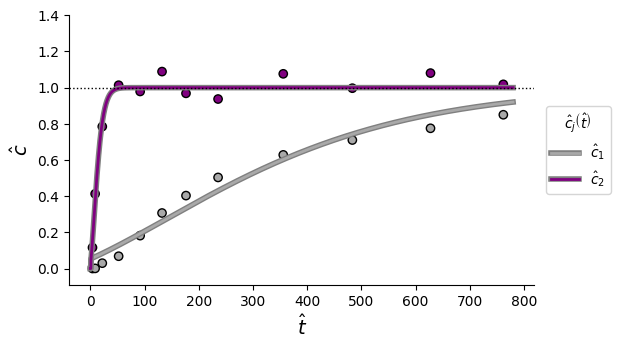

In [13]:
best_params = fitting_result[0]
best_params = 10**best_params

display(best_params)

p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=10.0**10.5,
    k_ads=best_params[:2],
    k_des=best_params[2:],
    C_0=experimental_data.c_0,
)

sim = Simulation(**p.nondim)
sim.cfl = 0.9
sim.end_time = 780
sim.solve()

plot_btc_and_data(sim, experimental_data)

In [14]:
p.nondim

{'Dam_ads': array([2.9622055 , 3.22890327]),
 'Dam_des': array([0.00868798, 0.24962956]),
 'kappa': array([4.44126086e-08, 1.64454250e-08]),
 'bc': array([1., 1.])}